# <center> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков и визуальный анализ данных
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *conda install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [2]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#conda install seaborn
import seaborn as sns
import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие 13 признаков:**
- time_diff1, ..., time_diff9 – промежутки между посещением 1 и 2 сайта, ..., 9 и 10 сайта в сессии (в секундах). Посещения сайтов не сторого упорядочены по времени, поэтому эти величины где-то могут быть отрицательными. Если сайтов в сессии меньше 10, разницы можно сделать нулевыми
- session_timespan – продолжительность сессии. Из-за того, что посещения сайтов не сторого упорядочены по времени, продолжительностью сессии будем считать разницу между максимальным и минимальным временем посещения сайтов в сессии (в секундах).
- #unique_sites – число уникальных сайтов в сессии 
- start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- day_of_week – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 13 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *time_diff1*, ..., *time_diff9*, *session_timespan*, *#unique_sites*, *start_hour*,*day_of_week*,*target* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def diff_for_date(a):
    if a.size < 2:
        return []
    else:
        return map(int, map(datetime.timedelta.total_seconds, np.diff(a).tolist()))

In [4]:
def prepare_train_set_with_fe(csv_files_mask, site_freq_path, feature_names,
                                    session_length=10, window_width=10):
    # Получаем список файлов, удовлетворяющих заданной маске
    list_of_files = glob(csv_files_mask)
    data = []
    # Feature engineering
    time_diff_list = []
    min_time = 0
    max_time = 0
    unique_sites = {}
    # Reading site dictionary
    with open(site_freq_path, "r") as fp:
        site_dict = pickle.load(fp)
    # Reading data files
    for path in list_of_files:
        all_sites_from_file = []
        all_times_from_file = []
        # Читаем файлы из списка
        with open(path, 'r') as fp:
            list_of_sites = []
            for line in fp:
                # Читаем строки из файла, каждую строку разбиваем на части
                list_of_tokens = line.strip().split(',')
                # Проверяем, что строка не пустая
                if len(list_of_tokens) != 3:
                    break
                # Добавляем элемент в словарь
                all_sites_from_file.append(site_dict[list_of_tokens[2]][0])
                all_times_from_file.append(list_of_tokens[1])
                user_id = int(list_of_tokens[0])
        n = len(all_sites_from_file)
        ind = 0
        while True:
            if ind + session_length > n-1:
                a = np.array(all_times_from_file[ind:n], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a) + [0 for _ in range(session_length - n + ind)]
                min_time = a.min()
                data.append(sites + [0 for _ in range(session_length - n + ind)] + 
                            time_diff +
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] +
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            else:
                a = np.array(all_times_from_file[ind:ind+session_length], dtype='datetime64')
                sites = all_sites_from_file[ind:ind+session_length]
                time_diff = diff_for_date(a)
                min_time = a.min()
                data.append(sites + 
                            time_diff + 
                            [int((a.max() - min_time).tolist().total_seconds())] +
                            [len(set(sites))] + 
                            [min_time.tolist().hour] + 
                            [min_time.tolist().weekday()] +
                            [user_id])
            ind += window_width
            if ind >= n:
                break
    df = pd.DataFrame(data,columns = feature_names)
    return df.drop_duplicates()

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe('capstone_websites_data/3users_toy/*', 
                                   site_freq_path='capstone_websites_data/site_freq_3users.pkl',
                                   feature_names=feature_names, session_length=10)

In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [7]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите session_length=10.**

In [8]:
from time import time

In [9]:
t_start = time()
train_data_10users = prepare_train_set_with_fe('capstone_websites_data/10users/*', 
                                               site_freq_path='capstone_websites_data/site_freq_10users.pkl',
                                               feature_names=feature_names, session_length=10)
print("Time elapsed", time() - t_start)

Time elapsed 0.718000173569


In [10]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,4,5,6,7,8,7,273,3,28,916,-1523,10,0,0,1,1523,8,8,4,31
1,7,8,7,7,9,10,11,12,13,14,1,0,1,0,0,1,0,163,105,271,8,8,4,31
2,7,15,16,17,17,8,17,17,10,3,4,3,8,1,0,14,1,242,0,273,7,8,4,31
3,18,19,20,17,21,17,17,17,17,22,1,0,0,2,1,1,25,1,0,31,6,8,4,31
4,23,24,25,17,26,27,28,29,30,31,0,0,1,1,1,1,0,1,1,6,10,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите session_length=10.**

In [11]:
t_start = time()
train_data_150users = prepare_train_set_with_fe('capstone_websites_data/150users/*', 
                                               site_freq_path='capstone_websites_data/site_freq_150users.pkl',
                                               feature_names=feature_names, session_length=10)
print("Time elapsed", time() - t_start)

Time elapsed 6.81100010872


**Сохраните в pickle-файлы *time_diff1*,..., *time_diff9, session_timespan, #unique_sites, start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [12]:
new_features = ['time_diff' + str(j) for j in range(1,10)] + \
               ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [13]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [14]:
with open('new_features_10users.pkl', 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open('new_features_150users.pkl', 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [15]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [16]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

In [45]:
matplotlib.rc('font', family='Arial')

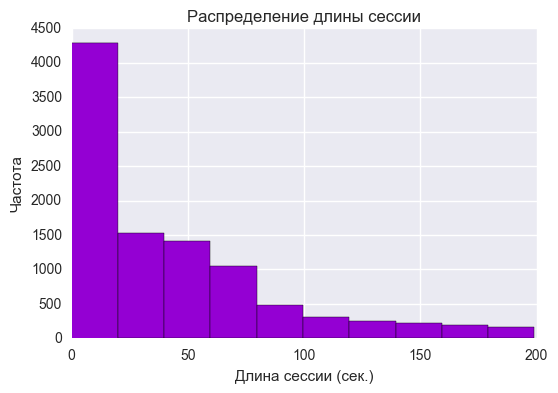

In [18]:
fig, ax = plt.subplots()
train_data_10users[train_data_10users.session_timespan < 200]['session_timespan'].plot(kind='hist', color='darkviolet', ax=ax)
ax.set_xlabel(u'Длина сессии (сек.)')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение длины сессии');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

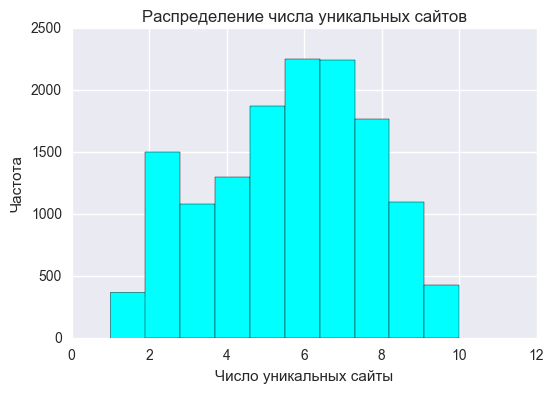

In [19]:
fig, ax = plt.subplots()
train_data_10users['#unique_sites'].plot(kind='hist', ax=ax, color='aqua')
ax.set_xlabel(u'Число уникальных сайты')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение числа уникальных сайтов');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

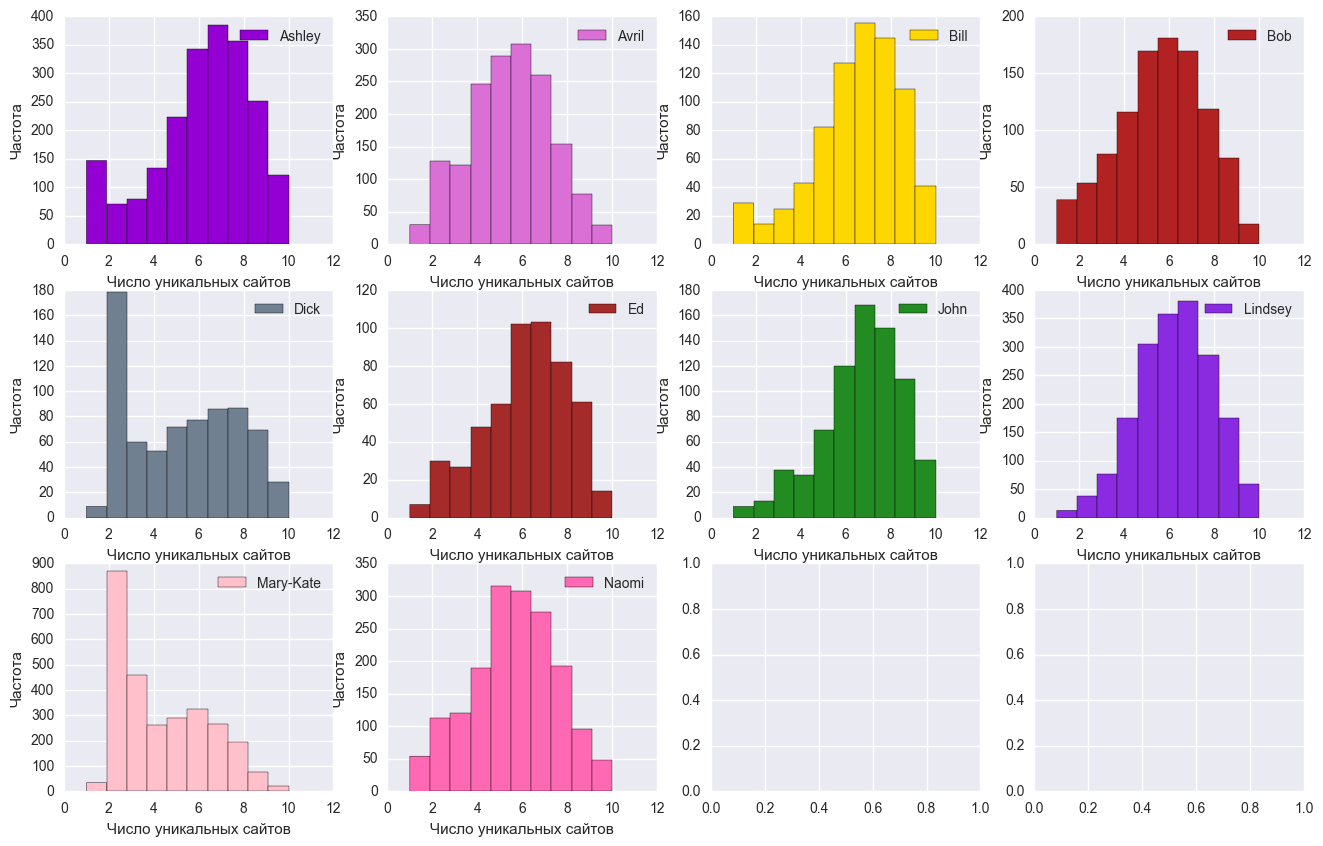

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['#unique_sites'].plot(kind='hist', ax=axes[idx/4, idx%4], color=color_dic[user], legend=True)
    axes[idx/4, idx%4].set_xlabel(u'Число уникальных сайтов')
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

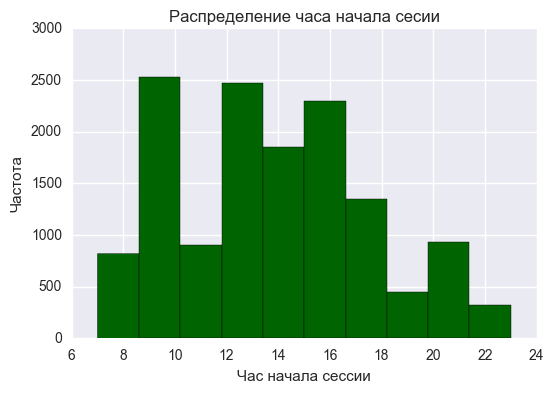

In [21]:
fig, ax = plt.subplots()
train_data_10users['start_hour'].plot(kind='hist', color='darkgreen', ax=ax)
ax.set_xlabel(u'Час начала сессии')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение часа начала сесии')

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

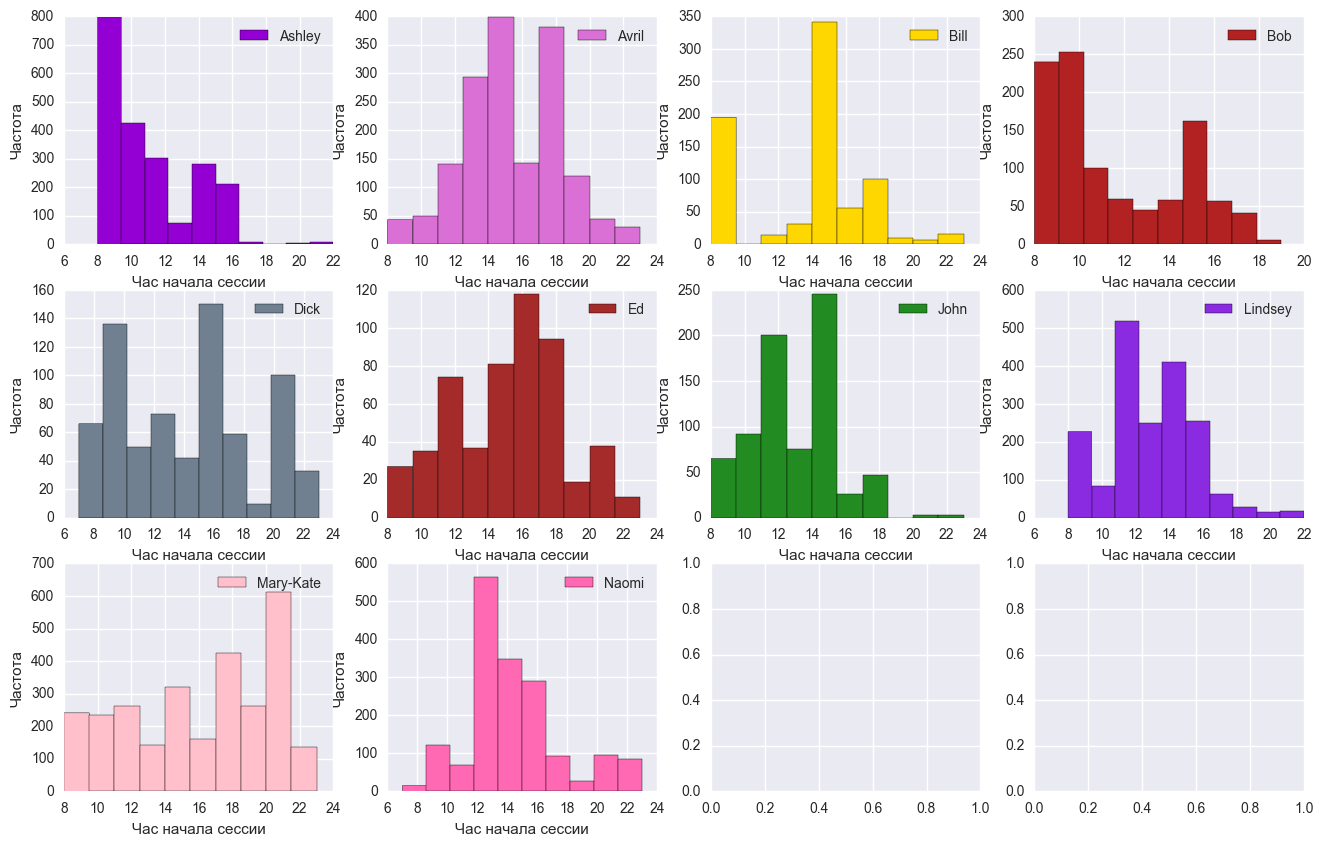

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['start_hour'].plot(kind='hist', ax=axes[idx/4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx/4, idx%4].set_xlabel(u'Час начала сессии')
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

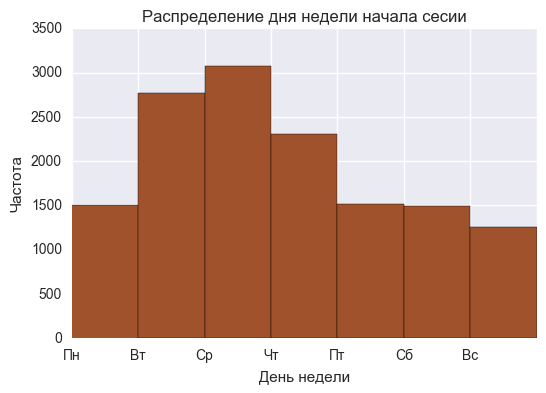

In [23]:
fig, ax = plt.subplots()
train_data_10users['day_of_week'].plot(kind='hist', ax=ax, color='sienna', bins=range(8))
ax.set_xlabel(u'День недели')
ax.set_ylabel(u'Частота')
ax.set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
ax.set_title(u'Распределение дня недели начала сесии');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку – на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

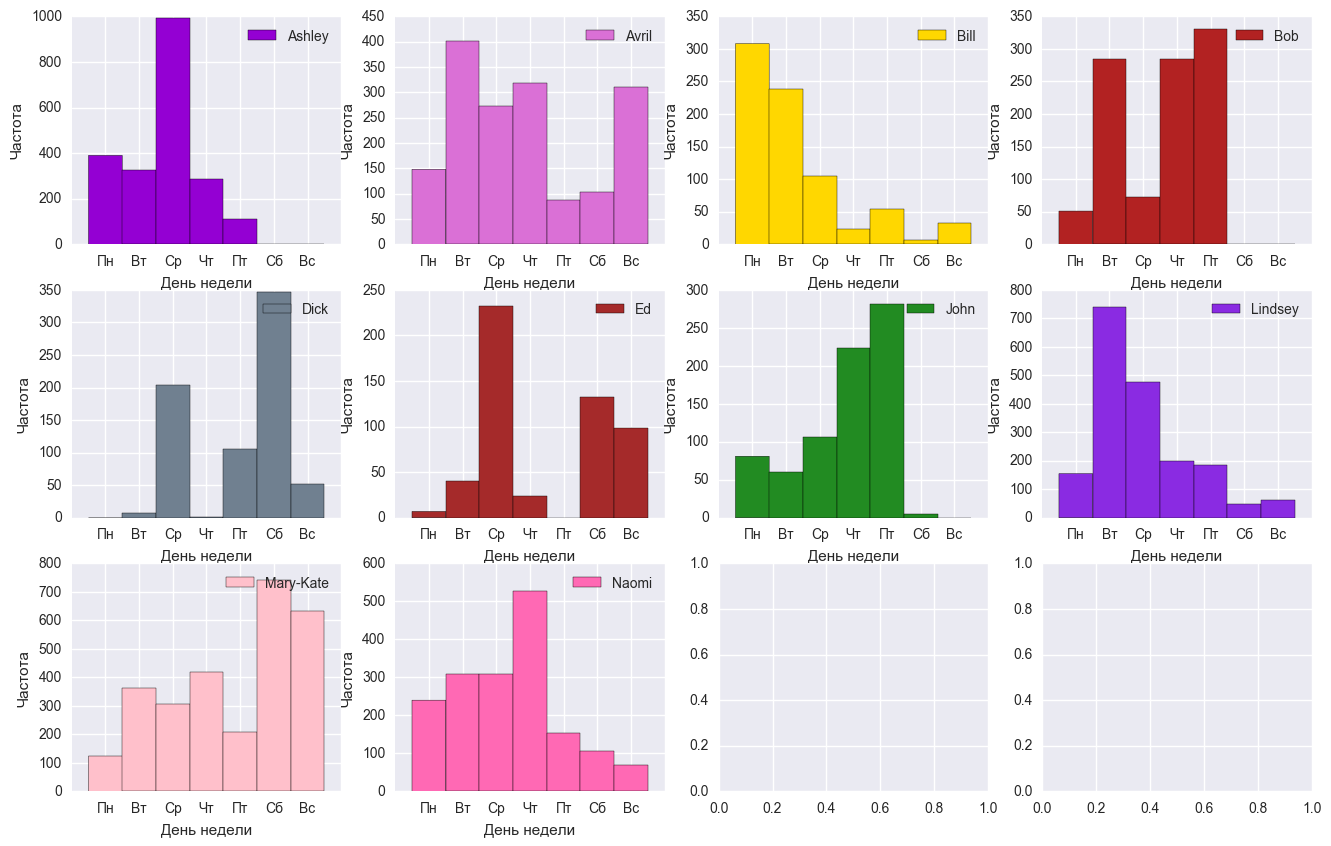

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    sub_df['day_of_week'].plot(kind='hist', ax=axes[idx/4, idx%4], 
                               color=color_dic[user], legend=True, bins=np.arange(-0.5,7,1), xticks=range(8))
    axes[idx/4, idx%4].set_xlabel(u'День недели')
    axes[idx/4, idx%4].set_xticklabels([u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб',  u'Вс'])
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Ashley на выходных не выходит в сеть, пик активности - среда. В основном посещает сайты в утренние часы. Любит сидеть на одном сайте, либо немного серфит интернет.
2. Avril чаще заходит в интернет в вт, ср, чт, вс. Сидит на разных сайтах - распределение нормальное. Зависает в интернете днем и ближе к вечеру.
3. Bill чаще бывает в интернете в понедельник и вторник. Пик активности раннее утро и день. Посещает разные сайты - распределение похоже на нормальное.
4. Bob не чаще всего бывает в вт, чт, пт, не бывает в выходные дни. Пик активности - утро. Посещает разные сайты - распр. похоже на нормальное.
5. Dick в основном засиживается в интернете в субботу и ср. Активность проявляет в разное время: и утром, и днем, и вечером. Любит засиживаться на одном-двух сайтах. 
6. Ed засиживается в интернете на выходных и в среду. Пик активности приходится на день. Посещает разные сайты - распр. похоже на нормальное.
7. John в основном выходит в интернете в чт и пт. Пик активности - позднее утро и день. Посещает разные сайты - распр. похоже на нормальное.
8. Lindsey в основном проводит время в интеренте по вт и ср. Наибольшую активность проявляет поздним утром и днем. Посещает разные сайты - распр. похоже на нормальное.
9. Mary-Kate проявляет наибольшую активность в выходные дни, минимальная активность в понедельник. На вечер и на утро приходятся пики ее активности. Любит зависать на одном-двух сайтах.
10. Naomi выходит в интернет в основном с пн по чт, чт - пик. В пт, сб, вс наблюдается снижение. Наибольшую активность проявляет поздним утром и в начале дня. Посещает разные сайты - распр. похоже на нормальное.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [25]:
with open("capstone_websites_data/site_freq_10users.pkl") as fid:
    site_freq_10 = pickle.load(fid)

In [26]:
def itemgetter_own(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item][1]
    return g

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [27]:
top10_popular = sorted(site_freq_10.items(), key=itemgetter_own(1), reverse=True)[:10]
top10_popular

[('www.google.fr', (51, 7803)),
 ('s.youtube.com', (209, 6227)),
 ('www.google.com', (8, 5048)),
 ('mail.google.com', (183, 4063)),
 ('www.facebook.com', (3, 4037)),
 ('apis.google.com', (129, 3747)),
 ('plus.google.com', (188, 2610)),
 ('accounts.google.com', (184, 2068)),
 ('r1---sn-gxo5uxg-jqbe.googlevideo.com', (213, 2020)),
 ('r3---sn-gxo5uxg-jqbe.googlevideo.com', (700, 1858))]

In [28]:
top10_freqs = [freq for _, (ind, freq) in top10_popular]
top10_sites = [site for site, _ in top10_popular]

In [29]:
print(zip(top10_sites, top10_freqs))

[('www.google.fr', 7803), ('s.youtube.com', 6227), ('www.google.com', 5048), ('mail.google.com', 4063), ('www.facebook.com', 4037), ('apis.google.com', 3747), ('plus.google.com', 2610), ('accounts.google.com', 2068), ('r1---sn-gxo5uxg-jqbe.googlevideo.com', 2020), ('r3---sn-gxo5uxg-jqbe.googlevideo.com', 1858)]


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

Сначала сделал как просят, а далее представил как мне кажется более удачный вариант

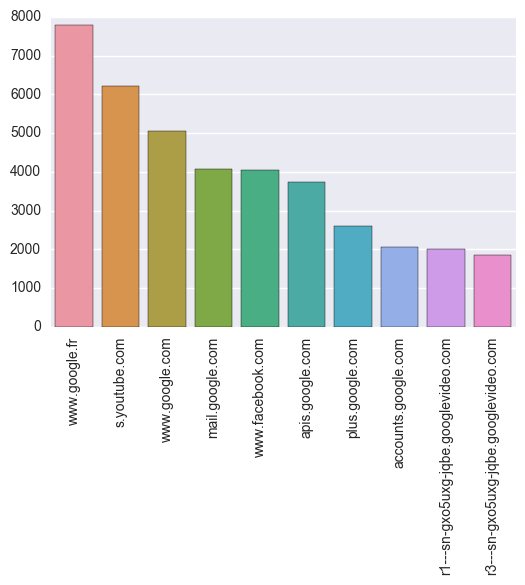

In [30]:
g = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=90);

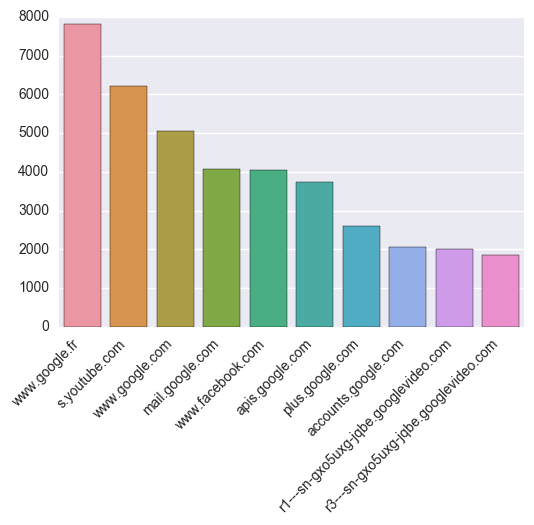

In [31]:
g = sns.barplot(x=top10_sites, y=top10_freqs)
plt.xticks(rotation=45, horizontalalignment='right');

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

1. На гистограмме длины сессии видно, что зависимость похожа на логарифмическую, поэтому рассмотрим такой признак,
как логарифм длины сессии.
2. Можно посмотреть на то, сколько в среднем проводит пользователь времени на сайте или, что лучше, взять логарифм времени.
3. Из анализа 10 пользователей можно предположить, что полезными будут следующие признаки: индикатор утра, дня, вечера и ночи.
4. Также можно ввести индикатор выходных.
5. Рассмотрим еще число time_diff, которые меньше 2 сек.
6. Можно ввести в рассмотрение пары посещенных сайтов, таким образом можно будет обнаружить взаимосвязи между посещаемыми сайтами.

In [32]:
from itertools import combinations

In [34]:
def feature_engineering(df_data):
    df_new_data = df_data.copy()
    df_new_data['log_session_timespan'] = df_new_data['session_timespan'].apply(lambda x: np.log(x + 1))
    df_new_data['session_ts_avg'] = df_new_data['session_timespan']/df_new_data['#unique_sites']
    df_new_data['log_sess_ts_avg'] = df_new_data['log_session_timespan']/df_new_data['#unique_sites']
    df_new_data['ind_morning'] = df_new_data['start_hour'].apply(lambda x: int(6 <= x and x < 12))
    df_new_data['ind_afternoon'] = df_new_data['start_hour'].apply(lambda x: int(12 <= x and x < 18))
    df_new_data['ind_evening'] = df_new_data['start_hour'].apply(lambda x: int(18 <= x and x < 24))
    df_new_data['ind_night'] = df_new_data['start_hour'].apply(lambda x: int(0 <= x and x < 6))
    df_new_data['ind_weekend'] = df_new_data['day_of_week'].apply(lambda x: int(x >= 5))
    time_diff_list = ['time_diff' + str(i) for i in range(1,10)]
    df_new_data['low_time_diff'] = (df_new_data[time_diff_list].apply(np.abs) < 2).sum(axis = 1)
    new_features_list = ['log_session_timespan', 'session_ts_avg', 'log_sess_ts_avg', 'ind_morning',
                        'ind_afternoon', 'ind_evening', 'ind_night', 'ind_weekend', 'low_time_diff']
    for (i, j) in combinations(['site' + str(i) for i in range(1, 11)], 2):
        df_new_data[i + "#" + j] = df_new_data[i].apply(str) + "#" + df_new_data[j].apply(str)
        new_features_list.append(i + "#" + j)
    return df_new_data[new_features_list]

In [35]:
new_features_10users = feature_engineering(train_data_10users)

In [36]:
new_features_150users = feature_engineering(train_data_150users)

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

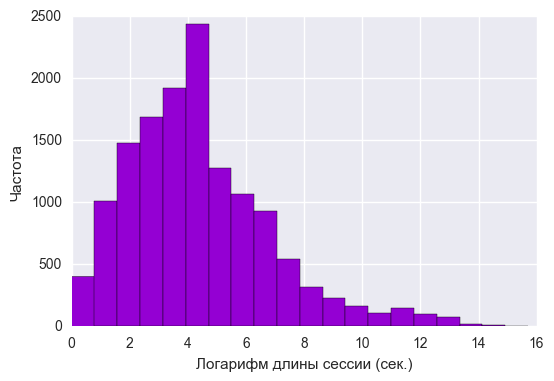

In [37]:
fig, ax = plt.subplots()
new_features_10users['log_session_timespan'].plot(kind='hist', color='darkviolet', ax=ax, bins = 20)
ax.set_xlabel(u'Логарифм длины сессии (сек.)')
ax.set_ylabel(u'Частота')

In [38]:
features_with_target = pd.concat([new_features_10users, train_data_10users['target']], axis=1)

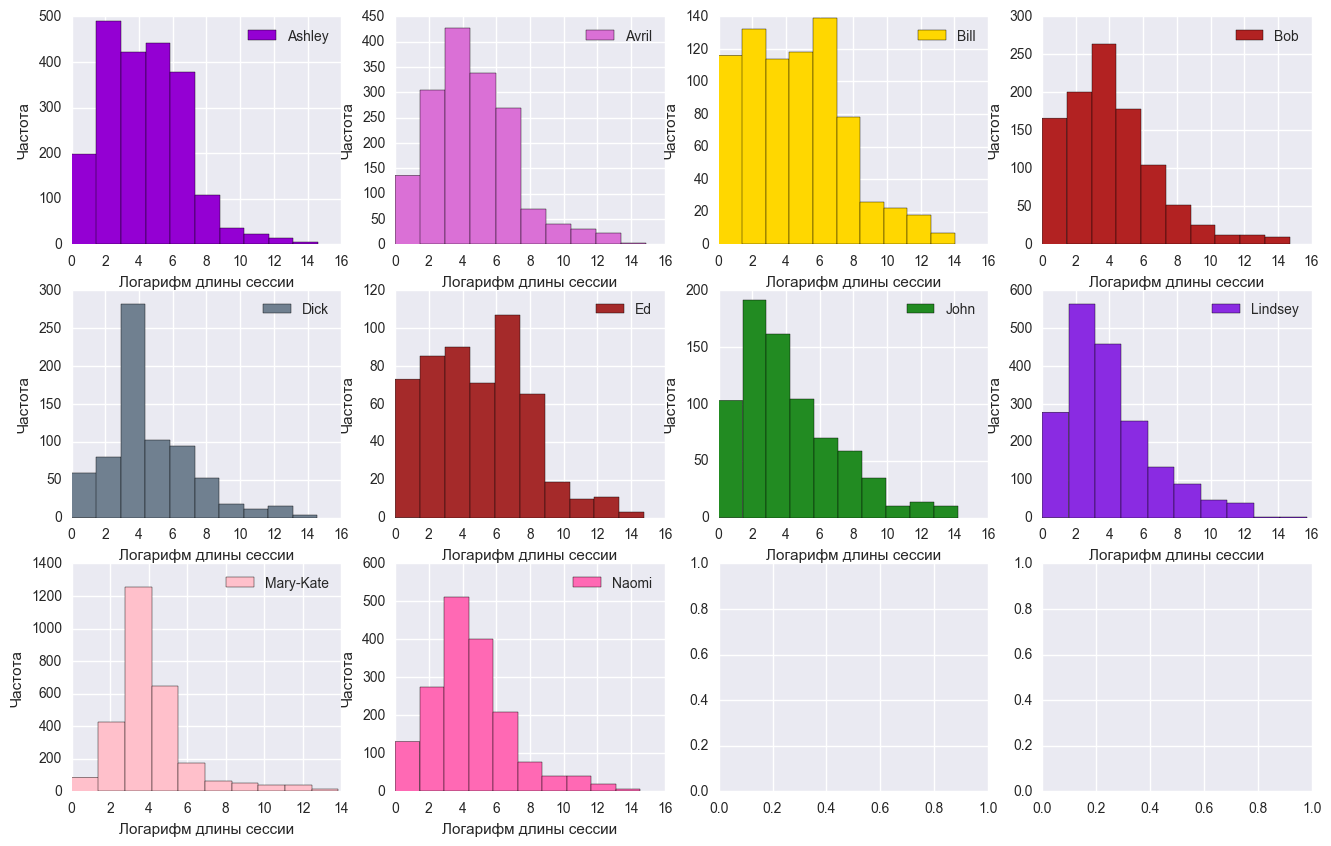

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')): 
    sub_df['log_session_timespan'].plot(kind='hist', ax=axes[idx/4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx/4, idx%4].set_xlabel(u'Логарифм длины сессии')
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

По этому признаку можем выделить несколько групп пользователей: Dick, Mary-Kate, Naomi; John, Lindsey, Bob, Avril; 
все остальные. Таким образом, данный признак позволяет отличить некоторых пользователей.

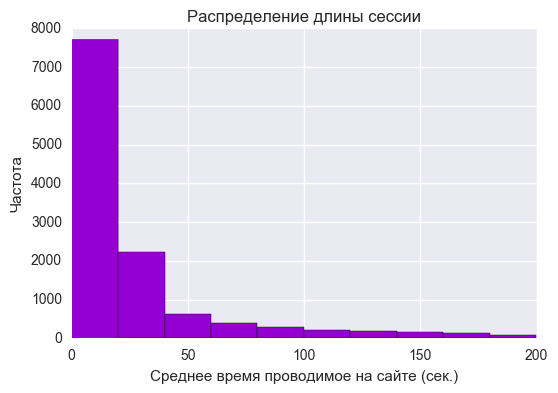

In [40]:
fig, ax = plt.subplots()
new_features_10users[new_features_10users.session_ts_avg < 200]['session_ts_avg'].plot(kind='hist', color='darkviolet', ax=ax)
ax.set_xlabel(u'Среднее время проводимое на сайте (сек.)')
ax.set_ylabel(u'Частота')
ax.set_title(u'Распределение длины сессии');

Признак не информативен, на мой взгляд.

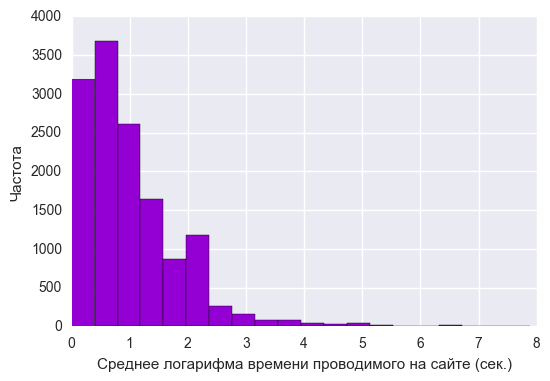

In [41]:
fig, ax = plt.subplots()
new_features_10users['log_sess_ts_avg'].plot(kind='hist', color='darkviolet', ax=ax, bins = 20)
ax.set_xlabel(u'Среднее логарифма времени проводимого на сайте (сек.)')
ax.set_ylabel(u'Частота')

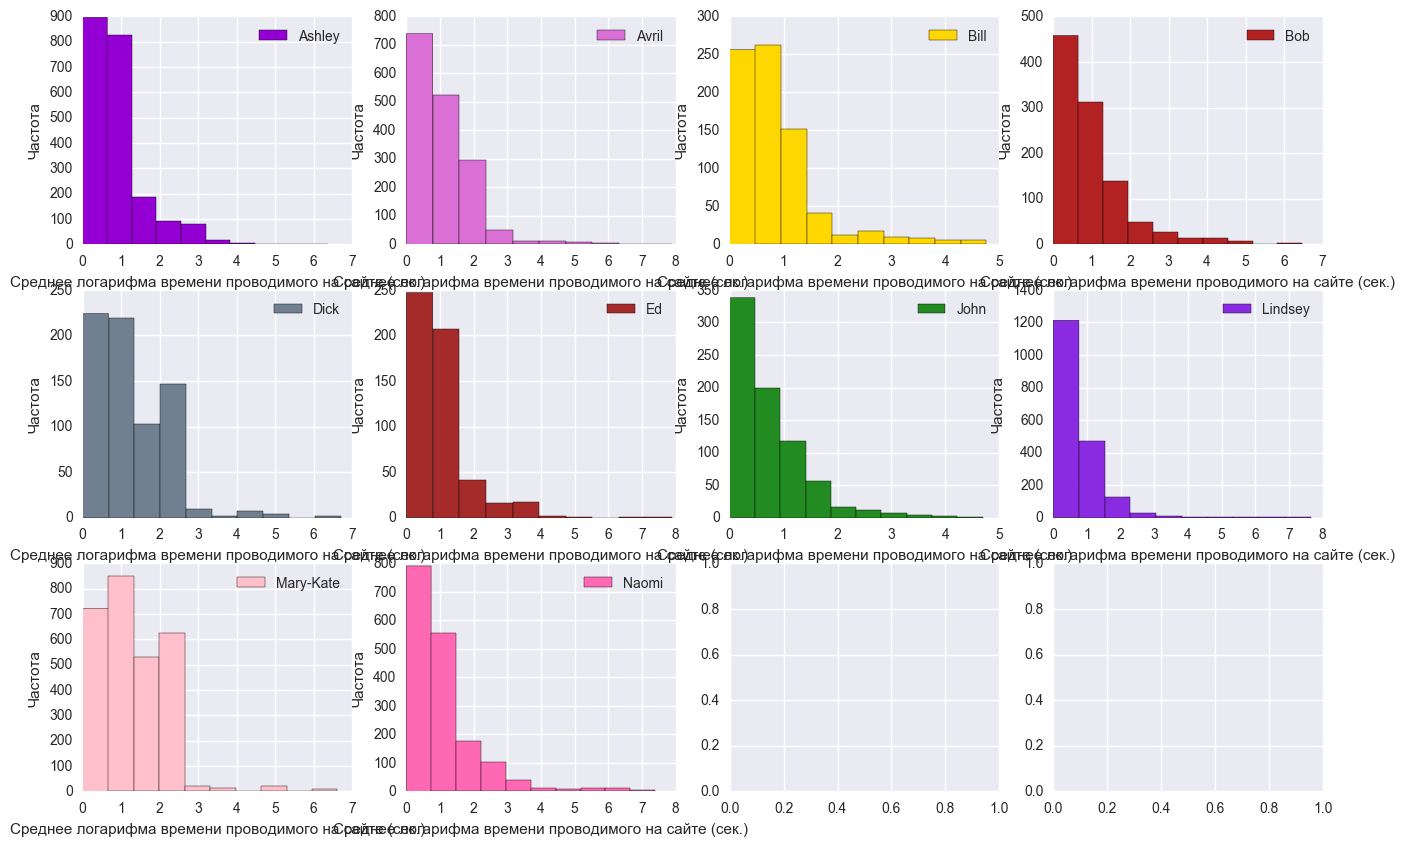

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')): 
    sub_df['log_sess_ts_avg'].plot(kind='hist', ax=axes[idx/4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx/4, idx%4].set_xlabel(u'Среднее логарифма времени проводимого на сайте (сек.)')
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

Видим, что есть различные виды распределений данного признака, т.е. его тоже можно использовать для идентификации пользователей.

Рассмотрим теперь индикаторы утра и т.д. и индикатор выходных.

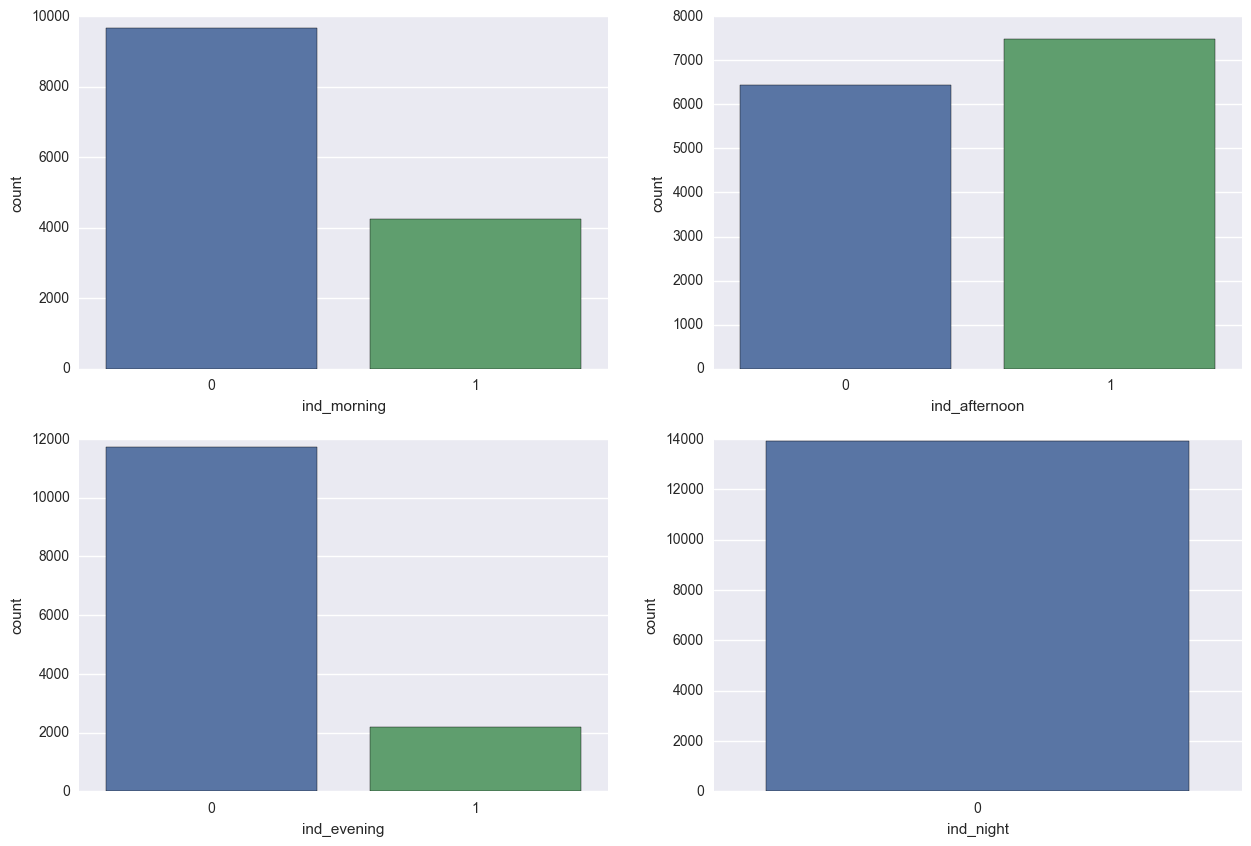

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
sns.countplot(new_features_10users['ind_morning'], ax=ax[0,0])
sns.countplot(new_features_10users['ind_afternoon'], ax=ax[0,1])
sns.countplot(new_features_10users['ind_evening'], ax=ax[1,0])
sns.countplot(new_features_10users['ind_night'], ax=ax[1,1])

Индикатор ночи не несет никакой информации. Также стоит отметить, что мало кто выходит в сеть вечером, следовательно - это может быть хорошим индикатором.

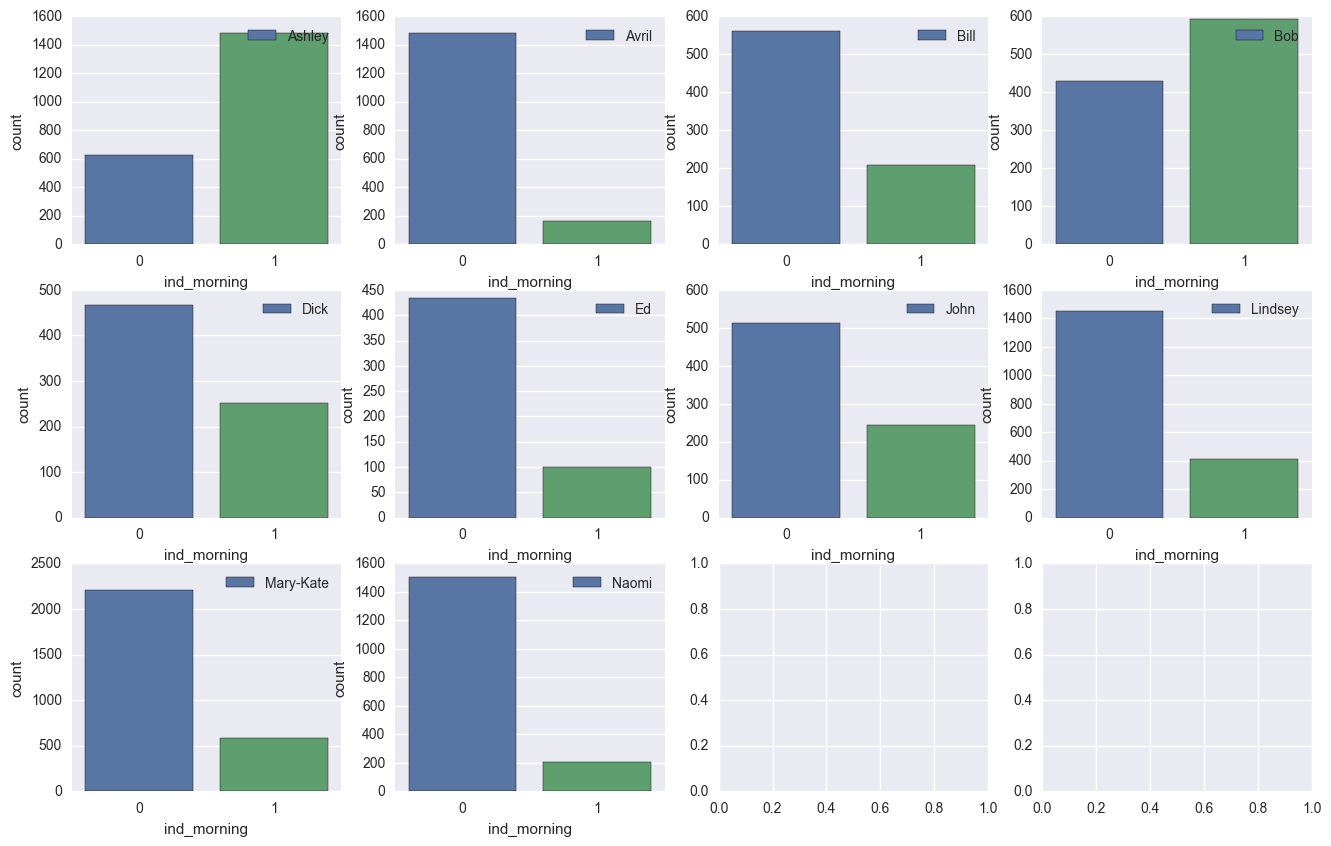

In [60]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')):
    sns.countplot(sub_df['ind_morning'], ax=axes[idx / 4, idx % 4], label=user)
    axes[idx / 4, idx % 4].legend()

Видим, что данный припзнак полезен при индентификации пользователей.

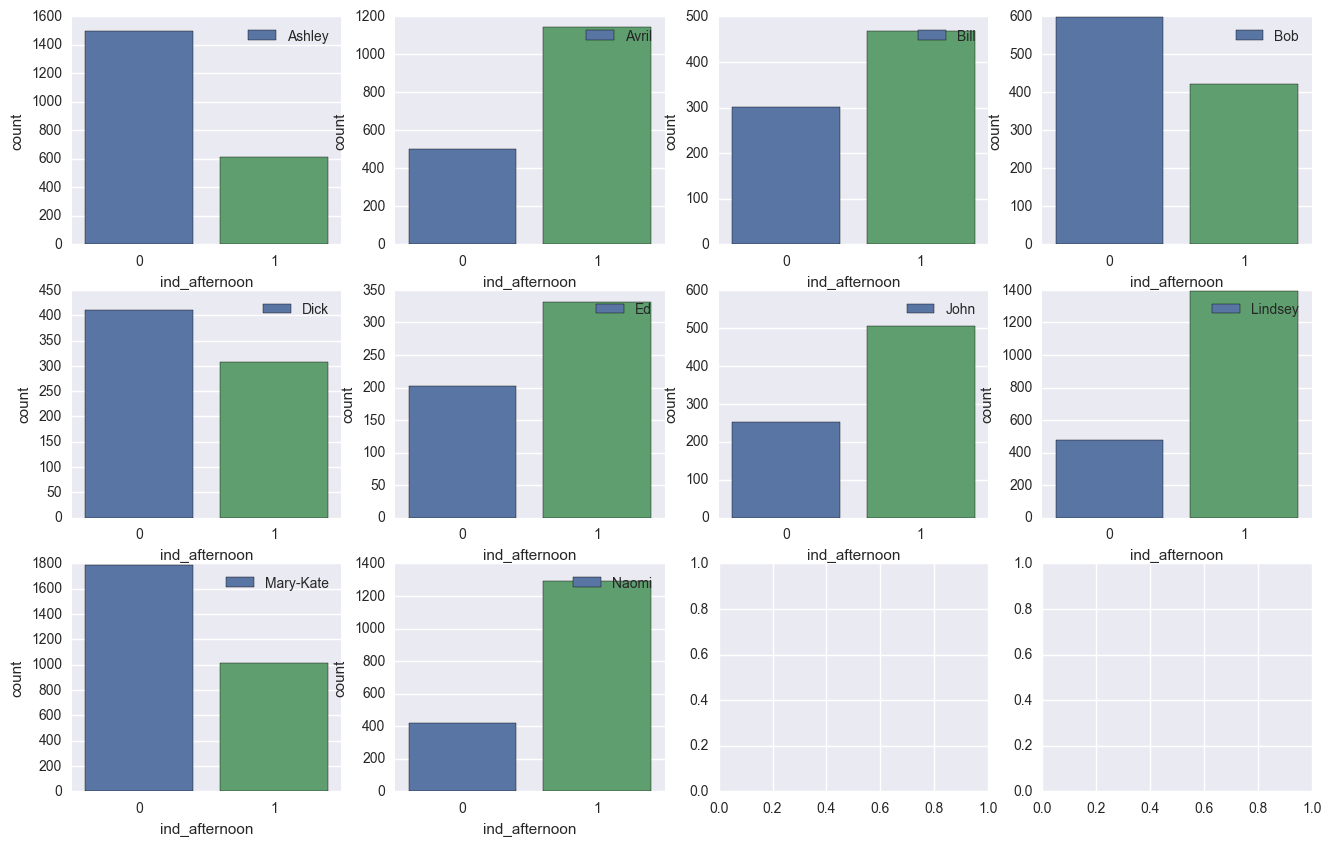

In [63]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')):
    sns.countplot(sub_df['ind_afternoon'], ax=axes[idx / 4, idx % 4], label=user)
    axes[idx / 4, idx % 4].legend()

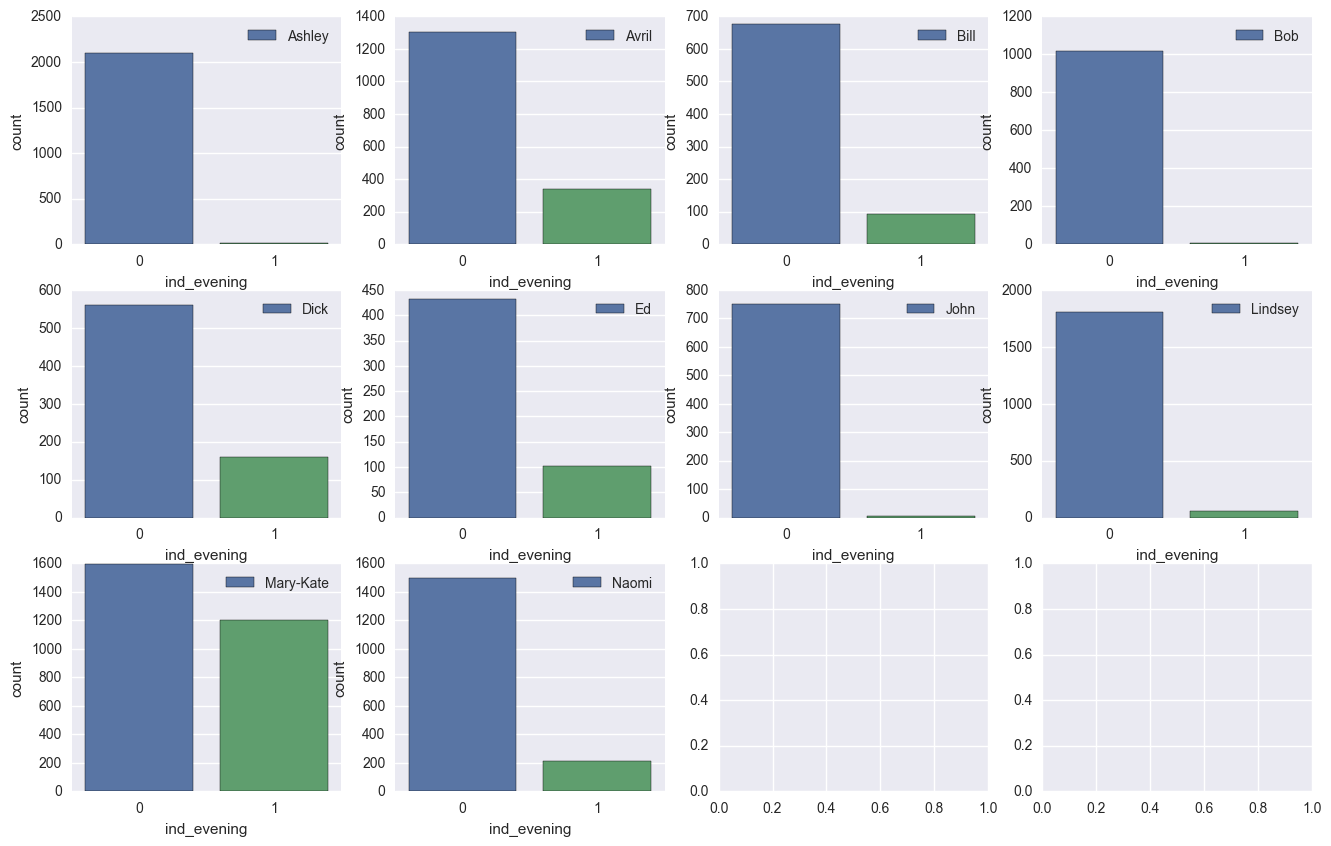

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')):
    sns.countplot(sub_df['ind_evening'], ax=axes[idx / 4, idx % 4], label=user)
    axes[idx / 4, idx % 4].legend()

Видим, что и последние два признака являются информативными.

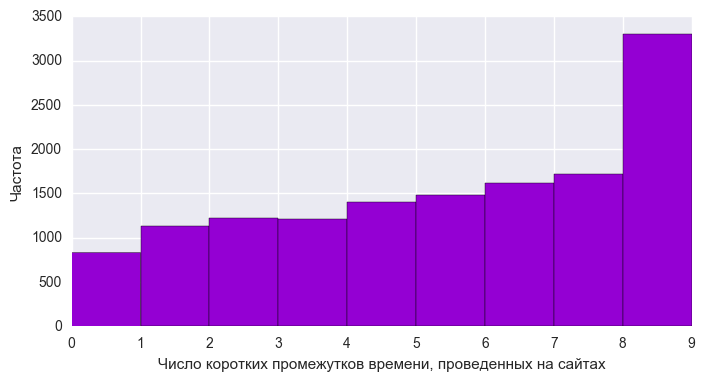

In [68]:
fig, ax = plt.subplots(figsize=(8,4))
new_features_10users['low_time_diff'].plot(kind='hist', color='darkviolet', ax=ax, bins = 9)
ax.set_xlabel(u'Число коротких промежутков времени, проведенных на сайтах')
ax.set_ylabel(u'Частота')

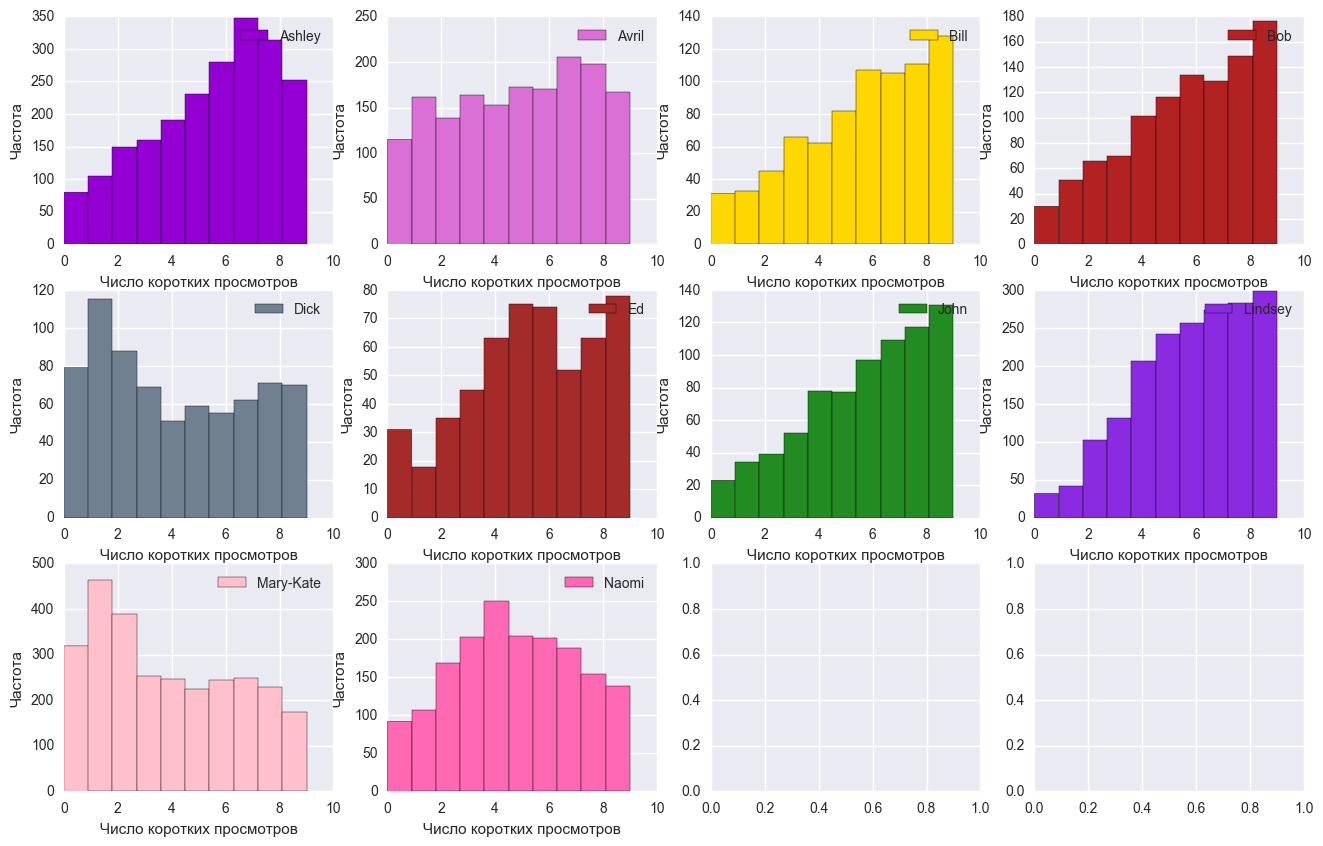

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(features_with_target, 'target')): 
    sub_df['low_time_diff'].plot(kind='hist', ax=axes[idx/4, idx%4], color=color_dic[user], legend=True, bins=10)
    axes[idx/4, idx%4].set_xlabel(u'Число коротких просмотров')
    axes[idx/4, idx%4].set_ylabel(u'Частота')
    axes[idx/4, idx%4].legend([user])

Этот признак также является полезным в различении пользователей

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [71]:
features_list = ['site' + str(i) for i in range(1, 11)] + \
                ['time_diff' + str(i) for i in range(1,10)] + ['#unique_sites', 'start_hour', 'day_of_week']

In [73]:
selected_features_10users = pd.concat([train_data_10users[features_list], new_features_10users.drop('ind_night',axis=1)],axis=1)
selected_features_150users=pd.concat([train_data_150users[features_list],new_features_150users.drop('ind_night',axis=1)],axis=1) 

In [74]:
# selected features – among (session_timespan, ..., day_of_week) and your own new ones
with open('selected_features_10users.pkl', 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl)
with open('selected_features_150users.pkl', 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя проекта посвящена общему описанию проекта (.ipynb или pdf) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящая [статья](https://habrahabr.ru/post/308162/) по этому ремеслу)
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями, не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

Далее пройдите чисто техническое задание "Проверка построенных признаков", цель которого – удостовериться, что все мы одинаково создали признаки *session_timespan, time_diff1,..., time_diff9, #unique_sites, start_hour* и *day_of_week*.